In [1]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

import matplotlib.pyplot as plt

import os
import createGraph

In [2]:
#Creating Graph from folders

graphs = []
labels = []

for i in range(1,5):
    path = os.getcwd() + '/graphsmallds/' + str(i) + '/'
    G,label = createGraph.createGraph(path)
    graphs.append(G)
    labels.append(label)
    
# Convert the list to a Categorical object
cat_label = pd.Categorical(labels, categories=[0,1])

# Create a Pandas Series object from the Categorical object
graph_labels = pd.Series(cat_label)

In [58]:
print(len(graphs))
print(labels)
print(graph_labels)

4
[0, 0, 0, 0]
0    0
1    0
2    0
3    0
dtype: category
Categories (2, int64): [0, 1]


# GCN GCN GCN

In [4]:
generator = PaddedGraphGenerator(graphs=graphs)

In [5]:
def create_graph_classification_model(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=1, activation="sigmoid")(predictions)

    # Let's create the Keras model and prepare it for training
    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(0.005), loss=binary_crossentropy, metrics=["acc"])

    return model


In [6]:
epochs = 200  # maximum number of training epochs
folds = 2  # the number of folds for k-fold cross validation
n_repeats = 5  # the number of repeats for repeated k-fold cross validation

In [7]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)

In [8]:
def train_fold(model, train_gen, test_gen, es, epochs):
    history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=0, callbacks=[es],
    )
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("acc")]

    return history, test_acc

In [9]:
def get_generators(train_index, test_index, graph_labels, batch_size):
    train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, batch_size=batch_size
    )
    test_gen = generator.flow(
        test_index, targets=graph_labels.iloc[test_index].values, batch_size=batch_size
    )

    return train_gen, test_gen

In [10]:
test_accs = []

stratified_folds = model_selection.RepeatedStratifiedKFold(
    n_splits=folds, n_repeats=n_repeats
).split(graph_labels, graph_labels)

for i, (train_index, test_index) in enumerate(stratified_folds):
    print(f"Training and evaluating on fold {i+1} out of {folds * n_repeats}...")
    train_gen, test_gen = get_generators(
        train_index, test_index, graph_labels, batch_size=30
    )

    model_1 = create_graph_classification_model(generator)

    history, acc = train_fold(model_1, train_gen, test_gen, es, epochs)

    test_accs.append(acc)

Training and evaluating on fold 1 out of 10...


2023-03-20 13:25:23.440513: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Training and evaluating on fold 2 out of 10...
Training and evaluating on fold 3 out of 10...
Training and evaluating on fold 4 out of 10...
Training and evaluating on fold 5 out of 10...
Training and evaluating on fold 6 out of 10...
Training and evaluating on fold 7 out of 10...
Training and evaluating on fold 8 out of 10...
Training and evaluating on fold 9 out of 10...
Training and evaluating on fold 10 out of 10...


In [11]:
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)


Accuracy over all folds mean: 1e+02% and std: 0.0%


Text(0, 0.5, 'Count')

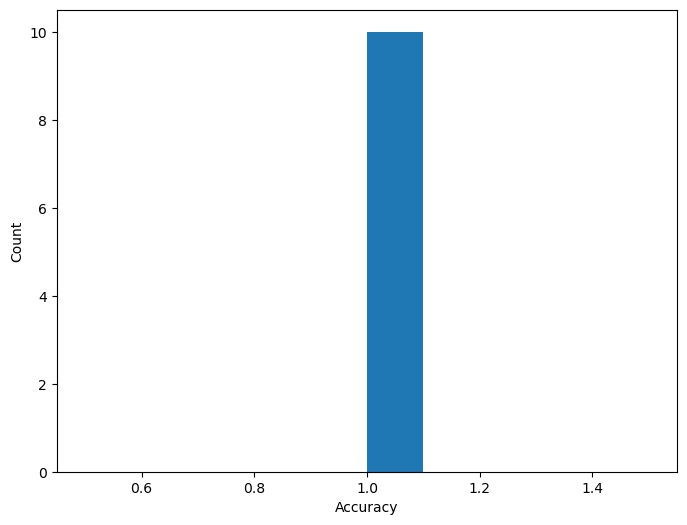

In [12]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")

# DCGNN DCGNN DCGNN

In [13]:
generator = PaddedGraphGenerator(graphs=graphs) #It uses same generator as above

In [14]:
# DCGNN GCN layers

k = 35  # the number of rows for the output tensor
layer_sizes = [32, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh"],
    k=k,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Use fn_output_signature instead


In [15]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

In [16]:
model_2 = Model(inputs=x_inp, outputs=predictions)

model_2.compile(
    optimizer=Adam(lr=0.0001), loss=binary_crossentropy, metrics=["acc"],
)

Splitting the graphs as train and test below

In [17]:
train_graphs, test_graphs = model_selection.train_test_split(
    graph_labels, train_size=0.9, test_size=None, stratify=graph_labels,
)

In [18]:

gen = PaddedGraphGenerator(graphs=graphs)

train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    batch_size=50,
    symmetric_normalization=False,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    batch_size=1,
    symmetric_normalization=False,
)

In [19]:
epochs = 100

In [20]:
history = model_2.fit(
    train_gen, epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True,
)

Epoch 1/100
1/1 [==============================] - 1s 760ms/step - loss: 0.6821 - acc: 0.3333 - val_loss: 0.5950 - val_acc: 1.0000
Epoch 2/100
1/1 [==============================] - 0s 22ms/step - loss: 0.5792 - acc: 0.6667 - val_loss: 0.5029 - val_acc: 1.0000
Epoch 3/100
1/1 [==============================] - 0s 21ms/step - loss: 0.5654 - acc: 1.0000 - val_loss: 0.4029 - val_acc: 1.0000
Epoch 4/100
1/1 [==============================] - 0s 22ms/step - loss: 0.4942 - acc: 1.0000 - val_loss: 0.2938 - val_acc: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 20ms/step - loss: 0.3440 - acc: 1.0000 - val_loss: 0.2123 - val_acc: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 21ms/step - loss: 0.3134 - acc: 1.0000 - val_loss: 0.1258 - val_acc: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 21ms/step - loss: 0.2219 - acc: 1.0000 - val_loss: 0.0699 - val_acc: 1.0000
Epoch 8/100
1/1 [==============================] - 0s 20ms/step - loss: 0.1545 - acc: 1.0

1/1 [==============================] - 0s 21ms/step - loss: 1.5807e-06 - acc: 1.0000 - val_loss: 2.4667e-15 - val_acc: 1.0000
Epoch 62/100
1/1 [==============================] - 0s 20ms/step - loss: 1.0032e-06 - acc: 1.0000 - val_loss: 2.3278e-15 - val_acc: 1.0000
Epoch 63/100
1/1 [==============================] - 0s 20ms/step - loss: 3.2792e-06 - acc: 1.0000 - val_loss: 2.2079e-15 - val_acc: 1.0000
Epoch 64/100
1/1 [==============================] - 0s 21ms/step - loss: 2.5576e-06 - acc: 1.0000 - val_loss: 2.1043e-15 - val_acc: 1.0000
Epoch 65/100
1/1 [==============================] - 0s 21ms/step - loss: 1.5060e-05 - acc: 1.0000 - val_loss: 2.0133e-15 - val_acc: 1.0000
Epoch 66/100
1/1 [==============================] - 0s 20ms/step - loss: 9.2860e-06 - acc: 1.0000 - val_loss: 1.9333e-15 - val_acc: 1.0000
Epoch 67/100
1/1 [==============================] - 0s 20ms/step - loss: 1.3958e-06 - acc: 1.0000 - val_loss: 1.8632e-15 - val_acc: 1.0000
Epoch 68/100
1/1 [======================

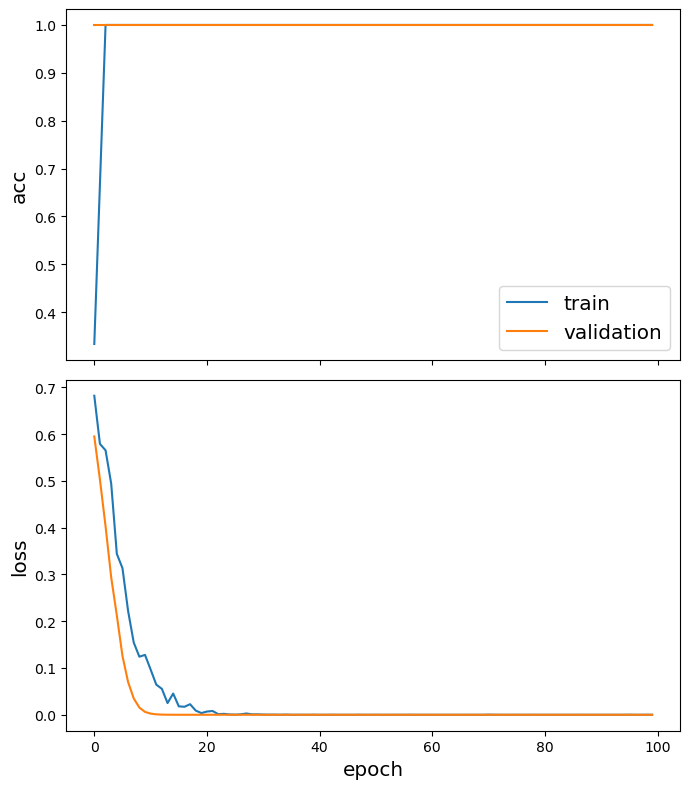

In [21]:
sg.utils.plot_history(history)

In [22]:
test_metrics = model_2.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model_2.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 15ms/step - loss: 8.8927e-16 - acc: 1.0000

Test Set Metrics:
	loss: 0.0000
	acc: 1.0000


# Generating New Labels for new graphs with pre-trained models


In [83]:
def generateNewData(model,graphs,LOW_THRESHOLD = 0.2,HIGH_THRESHOLD = 0.8):
    '''
    Creates labels for unlabeled graphs and returns new training data
    
    Inputs:
    -------
    
    model : Trained tf model that is used to predict/generate labels
    graphs: Graphs for which we generate new labels
    
    Outputs:
    --------
    new_graphs: List of graphs that the model can classify with confidence
    graph_labels: Labels for the above graphs
    
    
    '''
    
    new_graphs = []
    new_labels = []
    
    new_gen = PaddedGraphGenerator(graphs=graphs)
    
    create_gen = new_gen.flow(graphs,
    batch_size=1,
    symmetric_normalization=False,)
    
    pred_labels = model_1.predict(create_gen)
    
    for i in range(len(graphs)):
        pred_val = pred_labels[i]
    
        if pred_val < LOW_THRESHOLD:
            new_graphs.append(graphs[i])
            new_labels.append(0)
        
        elif pred_val > HIGH_THRESHOLD:
            new_graphs.append(graphs[i])
            new_labels.append(1)
        
    # Convert the list to a Categorical object
    cat_label = pd.Categorical(new_labels, categories=[0,1])

    # Create a Pandas Series object from the Categorical object
    graph_labels = pd.Series(cat_label)
    
    
    return new_graphs,graph_labels
    
    
new_gs,new_lbls = generateNewData(model_2,graphs)
print(new_gs)
print(new_lbls)

4/4 [==============================] - 0s 999us/step
[<stellargraph.core.graph.StellarGraph object at 0x288fb2f10>, <stellargraph.core.graph.StellarGraph object at 0x1110d8a00>, <stellargraph.core.graph.StellarGraph object at 0x288fb2fd0>, <stellargraph.core.graph.StellarGraph object at 0x1110d8850>]
0    0
1    0
2    0
3    0
dtype: category
Categories (2, int64): [0, 1]


In [80]:
#Appending new data to old
def appendTwoDatasets(graphs_old,graph_labels_old,graphs_new,graph_labels_new):
    '''
    Takes in old graphs, labels and the new ones and appends them to return one dataset
    
    
    Inputs:
    -------
    graphs_old: List of old graph objects
    graph_labels_old: Pandas categorical series object of old labels
    new ones are new of corresponding data
    
    Outputs:
    --------
    
    '''
    final_graphs = graphs_old + graphs_new
    final_labels = pd.concat([graph_labels_old, graph_labels_new], ignore_index=True)
    
    return final_graphs,final_labels

In [82]:
temp1,temp2 = appendTwoDatasets(graphs,graph_labels,graphs,graph_labels)
print(len(temp1))
print(len(temp2))

8
8


In [ ]:
def generateNewDataset(graphs_old,graphs_new,model,graphs_unlabeled,):